In [1]:
from github import Github
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import os

ROLLING_WINDOW = 5

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger('urllib3').setLevel(logging.INFO)
logging.getLogger('github').setLevel(logging.INFO)
log = logging.getLogger(__name__)

In [3]:
GITHUB_TOKEN = os.getenv('GITHUB_PUBLIC_READ_TOKEN')
assert GITHUB_TOKEN is not None

In [4]:
CSV_PATH = 'CSV'
GITHUB_REPO = 'CSSEGISandData/COVID-19'

def get_csvs():
    g = Github(login_or_token=GITHUB_TOKEN)
    repo = g.get_repo(GITHUB_REPO)
    c = repo.get_contents('csse_covid_19_data/csse_covid_19_daily_reports')

    local_csvs = glob.glob(os.path.join(CSV_PATH, '*.csv'))
    local_csvs = list(map(os.path.basename, local_csvs))
    need_dowload = [f for f in c if f.path.endswith('.csv') and os.path.basename(f.path) not in local_csvs]
    for cf in need_dowload:
        fn = os.path.basename(cf.path)
        log.info(f'writing {fn}')
        with open(os.path.join(CSV_PATH, fn), 'wb') as f:
            f.write(cf.decoded_content)

In [5]:
get_csvs()

In [6]:
def path_to_date(path):
    path = os.path.basename(path)
    path = os.path.splitext(path)[0]
    date = pd.Timestamp(f'{path[-4:]}-{path[:2]}-{path[3:5]}')
    return date

def df_from_csv(path):
    column_info = {
        'FIPS': '',
        'Admin2': '',
        'Province_State': 'Province/State',
        'Country_Region': 'Country/Region',
        'Last_Update': 'Last Update',
        'Lat': 'Latitude',
        'Long_': 'Longitude',
        'Confirmed': 'Confirmed',
        'Deaths': 'Deaths',
        'Recovered': 'Recovered',
        'Active': '',
        'Combined_Key': '',
    }

    def combined_key(row):
        keys = ['Admin2', 'Province_State', 'Country_Region']
        values = [row[key] for key in keys]
        r = ', '.join((v for v in values if v and pd.notna(v)))
        return r

    log.debug(f'reading {path}')
    df = pd.read_csv(path)
    df['Date'] = path_to_date(path)
    column_names = list(df.columns)
    for column_name, old_column_name in column_info.items():
        if column_name in column_names:
            continue
        if old_column_name:
            if old_column_name in column_names:
                log.debug(f'{path}: renaming {old_column_name} to {column_name}')
                df.rename(columns={old_column_name: column_name}, inplace=True)
                continue
            else:
                log.debug(f'{path}: adding missing column {column_name}')
                df[column_name] = np.nan
                continue
        if column_name in ['FIPS', 'Admin2']:
            log.debug(f'{path}: adding missing column {column_name}')
            df[column_name] = np.nan
        elif column_name == 'Active':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Active'] = df['Confirmed'] - df['Deaths'] - df['Recovered']
        elif column_name == 'Combined_Key':
            log.debug(f'{path}: adding missing column {column_name}')
            df['Combined_Key'] = df.apply(combined_key, axis=1)
        else:
            raise NotImplementedError(f'Unexpected column name: {column_name}')

    return df

In [7]:
csv_files = glob.glob(os.path.join(CSV_PATH, '*.csv'))
csv_files.sort(reverse=True)
covid = pd.concat(df_from_csv(csv_file) for csv_file in csv_files)

In [8]:
print(covid.columns)
covid.head(2)

Index(['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
       'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active',
       'Combined_Key', 'Incident_Rate', 'Case_Fatality_Ratio', 'Date',
       'Incidence_Rate', 'Case-Fatality_Ratio'],
      dtype='object')


FIPS Admin2 Province_State Country_Region          Last_Update       Lat  \
0   NaN    NaN            NaN    Afghanistan  2021-01-01 05:23:07  33.93911   
1   NaN    NaN            NaN        Albania  2021-01-01 05:23:07  41.15330   

       Long_  Confirmed  Deaths  Recovered   Active Combined_Key  \
0  67.709953    51526.0  2191.0    41727.0      0.0  Afghanistan   
1  20.168300    58316.0  1181.0    33634.0  23501.0      Albania   

   Incident_Rate Case_Fatality_Ratio       Date  Incidence_Rate  \
0       0.000000             4.25222 2020-12-31             NaN   
1    2026.409062             2.02517 2020-12-31             NaN   

   Case-Fatality_Ratio  
0                  NaN  
1                  NaN

Looks like 'China' and 'Mainland China' are (almost) equivalent. But the dates overlap

In [9]:
china = covid[covid.Country_Region=='China']
mainland_china = covid[covid.Country_Region=='Mainland China']
print(china.Province_State.unique())
print(mainland_china.Province_State.unique())
print(china.Date.describe())
print(mainland_china.Date.describe())

['Anhui' 'Beijing' 'Chongqing' 'Fujian' 'Gansu' 'Guangdong' 'Guangxi'
 'Guizhou' 'Hainan' 'Hebei' 'Heilongjiang' 'Henan' 'Hong Kong' 'Hubei'
 'Hunan' 'Inner Mongolia' 'Jiangsu' 'Jiangxi' 'Jilin' 'Liaoning' 'Macau'
 'Ningxia' 'Qinghai' 'Shaanxi' 'Shandong' 'Shanghai' 'Shanxi' 'Sichuan'
 'Tianjin' 'Tibet' 'Xinjiang' 'Yunnan' 'Zhejiang']
['Gansu' 'Hebei' 'Hubei' 'Guangdong' 'Henan' 'Zhejiang' 'Hunan' 'Anhui'
 'Jiangxi' 'Shandong' 'Jiangsu' 'Chongqing' 'Sichuan' 'Heilongjiang'
 'Beijing' 'Shanghai' 'Fujian' 'Guangxi' 'Shaanxi' 'Yunnan' 'Hainan'
 'Guizhou' 'Tianjin' 'Shanxi' 'Liaoning' 'Jilin' 'Xinjiang'
 'Inner Mongolia' 'Ningxia' 'Qinghai' 'Tibet']
count                   11220
unique                    340
top       2020-09-01 00:00:00
freq                       33
first     2020-03-11 00:00:00
last      2021-02-13 00:00:00
Name: Date, dtype: object
count                    1517
unique                     51
top       2020-01-31 00:00:00
freq                       31
first     2020-01-22

Take a look at the 'Mainland China' records which overlap with the 'China' records

In [10]:
first_china = china.Date.min()
print(f"'China' records start at {first_china}")
overlapping_mainland = mainland_china[mainland_china.Date>=first_china]
print(overlapping_mainland)

'China' records start at 2020-03-11 00:00:00
     FIPS Admin2 Province_State  Country_Region          Last_Update      Lat  \
211   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
212   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   
206   NaN    NaN          Gansu  Mainland China  2020-03-11T02:18:28  36.0611   
207   NaN    NaN          Hebei  Mainland China  2020-03-11T02:18:29  38.0428   

        Long_  Confirmed  Deaths  Recovered  Active           Combined_Key  \
211  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
212  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   
206  103.8343        0.0     0.0        0.0     0.0  Gansu, Mainland China   
207  114.5149        0.0     0.0        0.0     0.0  Hebei, Mainland China   

     Incident_Rate Case_Fatality_Ratio       Date  Incidence_Rate  \
211            NaN                 NaN 2020-03-12             NaN   
212            NaN  

Looks like the 'Mainland China' records which overlap with the 'China' records don't have numbers for Confirmed, Deaths, Recovered, or Active. We might as well get rid of them and then rename 'Mainland China' to 'China'

In [11]:
covid.drop(covid[(covid.Country_Region=='Mainland China') & (covid.Date>=first_china)].index, inplace=True)
covid.loc[covid.Country_Region=='Mainland China', 'Country_Region'] = 'China'

Also 'South Korea" and 'Korea, South' seem to be redundant. But there is no overlap

In [12]:
s_korea = covid[covid.Country_Region == 'South Korea']
ro_korea = covid[covid.Country_Region == 'Republic of Korea']
korea_s = covid[covid.Country_Region == 'Korea, South']
print('s_korea:')
print(s_korea.Date.describe())
print('ro_korea:')
print(ro_korea.Date.describe())
print('korea_s:')
print(korea_s.Date.describe())


s_korea:
count                      48
unique                     48
top       2020-02-17 00:00:00
freq                        1
first     2020-01-22 00:00:00
last      2020-03-09 00:00:00
Name: Date, dtype: object
ro_korea:
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object
korea_s:
count                     340
unique                    340
top       2020-03-13 00:00:00
freq                        1
first     2020-03-11 00:00:00
last      2021-02-13 00:00:00
Name: Date, dtype: object


Replace 'South Korea' and 'Republic of Korea' with 'Korea, South'

In [13]:
covid.loc[covid.Country_Region.isin(['South Korea', 'Republic of Korea']), 'Country_Region'] = 'Korea, South'

Finally 'Iran' and 'Iran (Islamic Republic of)' seem to be redundant

In [14]:
iran = covid[covid.Country_Region == 'Iran']
iran_r= covid[covid.Country_Region == 'Iran (Islamic Republic of)']
print(iran.Date.describe())
print(iran_r.Date.describe())

count                     360
unique                    360
top       2020-03-13 00:00:00
freq                        1
first     2020-02-19 00:00:00
last      2021-02-13 00:00:00
Name: Date, dtype: object
count                       1
unique                      1
top       2020-03-10 00:00:00
freq                        1
first     2020-03-10 00:00:00
last      2020-03-10 00:00:00
Name: Date, dtype: object


In [15]:
covid.loc[covid.Country_Region == 'Iran (Islamic Republic of)', 'Country_Region'] = 'Iran'

In [16]:
# set defaults for Deaths, Recovered, and Confirmed
for c in ['Deaths', 'Recovered', 'Confirmed']:
    covid[c].fillna(value=0, inplace=True)

covid.Active.fillna(covid.Confirmed - covid.Deaths - covid.Recovered, inplace = True)

In [17]:
active_wrong = covid[covid.Active != (covid.Confirmed-covid.Deaths-covid.Recovered)]
active_wrong

FIPS      Admin2 Province_State Country_Region          Last_Update  \
0         NaN         NaN            NaN    Afghanistan  2021-01-01 05:23:07   
88        NaN         NaN         Quebec         Canada  2021-01-01 05:23:07   
196       NaN         NaN            NaN    El Salvador  2021-01-01 05:23:07   
198       NaN         NaN            NaN        Eritrea  2021-01-01 05:23:07   
242       NaN         NaN            NaN          Haiti  2021-01-01 05:23:07   
...       ...         ...            ...            ...                  ...   
2482  34037.0      Sussex     New Jersey             US  2021-01-02 05:22:33   
2484  34039.0       Union     New Jersey             US  2021-01-02 05:22:33   
2485  34041.0      Warren     New Jersey             US  2021-01-02 05:22:33   
2734  90038.0  Unassigned   North Dakota             US  2021-01-02 05:22:33   
3530  48439.0     Tarrant          Texas             US  2021-01-02 05:22:33   

            Lat      Long_  Confirmed  Deaths  Recovered    Active  \
0     33.939110  67.709953    51526.0  2191.0    41727.0       0.0   
88    52.939900 -73.549100   202641.0  8356.0   170045.0   24370.0   
196   13.794200 -88.896500    45960.0  1327.0    45960.0    3512.0   
198   15.179400  39.782300     1320.0     3.0      643.0     641.0   
242   18.971200 -72.285200     9999.0   236.0     8624.0    1155.0   
...         ...        ...        ...     ...        ...       ...   
2482  41.138916 -74.691182     5122.0   215.0        0.0    4327.0   
2484  40.658354 -74.306801    41887.0  1559.0        0.0   35275.0   
2485  40.859518 -74.995565     4378.0   183.0        0.0    3795.0   
2734        NaN        NaN        0.0     7.0        0.0       0.0   
3530  32.771438 -97.291016   153365.0  1552.0        0.0  148558.0   

                      Combined_Key  Incident_Rate Case_Fatality_Ratio  \
0                      Afghanistan       0.000000             4.25222   
88                  Quebec, Canada    2373.491890              4.0594   
196                    El Salvador     708.581186             2.88729   
198                        Eritrea      37.220560           0.0798722   
242                          Haiti      87.831362             2.35647   
...                            ...            ...                 ...   
2482        Sussex, New Jersey, US    3233.016343              4.7336   
2484         Union, New Jersey, US    6620.759570              4.2325   
2485        Warren, New Jersey, US    3778.962068              4.6003   
2734  Unassigned, North Dakota, US            NaN                 NaN   
3530            Tarrant, Texas, US    7134.503202            0.963974   

           Date  Incidence_Rate  Case-Fatality_Ratio  
0    2020-12-31             NaN                  NaN  
88   2020-12-31             NaN                  NaN  
196  2020-12-31             NaN                  NaN  
198  2020-12-31             NaN                  NaN  
242  2020-12-31             NaN                  NaN  
...         ...             ...                  ...  
2482 2021-01-01             NaN                  NaN  
2484 2021-01-01             NaN                  NaN  
2485 2021-01-01             NaN                  NaN  
2734 2021-01-01             NaN                  NaN  
3530 2021-01-01             NaN                  NaN  

[103362 rows x 17 columns]

In [18]:
covid.Active = covid.Confirmed-covid.Deaths-covid.Recovered

We only want to work on sums per country and date and the dataframe will be indexed by country and date


In [19]:
covid = covid.drop(columns=['FIPS', 'Lat', 'Long_']).groupby(by=['Country_Region', 'Date']).sum()

In [20]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 65668 entries, (' Azerbaijan', Timestamp('2020-02-28 00:00:00')) to ('occupied Palestinian territory', Timestamp('2020-03-17 00:00:00'))
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            65668 non-null  float64
 1   Deaths               65668 non-null  float64
 2   Recovered            65668 non-null  float64
 3   Active               65668 non-null  float64
 4   Incident_Rate        65668 non-null  float64
 5   Incidence_Rate       65668 non-null  float64
 6   Case-Fatality_Ratio  65668 non-null  float64
dtypes: float64(7)
memory usage: 3.8+ MB


In [21]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
 Azerbaijan    2020-02-28        1.0     0.0        0.0     1.0   
Afghanistan    2020-02-24        1.0     0.0        0.0     1.0   
               2020-02-25        1.0     0.0        0.0     1.0   
               2020-02-26        1.0     0.0        0.0     1.0   
               2020-02-27        1.0     0.0        0.0     1.0   

                           Incident_Rate  Incidence_Rate  Case-Fatality_Ratio  
Country_Region Date                                                            
 Azerbaijan    2020-02-28            0.0             0.0                  0.0  
Afghanistan    2020-02-24            0.0             0.0                  0.0  
               2020-02-25            0.0             0.0                  0.0  
               2020-02-26            0.0             0.0                  0.0  
               2020-02-27            0.0             0.0                  0.0

Get top n impacted countries

In [22]:
N_TOP_IMPACTED = 50
top_impacted = covid.groupby(level=0).max().Confirmed.nlargest(n=N_TOP_IMPACTED).index
top_impacted

Index(['US', 'India', 'Brazil', 'United Kingdom', 'Russia', 'France', 'Spain',
       'Italy', 'Turkey', 'Germany', 'Colombia', 'Argentina', 'Mexico',
       'Poland', 'Iran', 'South Africa', 'Ukraine', 'Peru', 'Indonesia',
       'Czechia', 'Netherlands', 'Canada', 'Portugal', 'Chile', 'Romania',
       'Belgium', 'Israel', 'Iraq', 'Sweden', 'Pakistan', 'Philippines',
       'Switzerland', 'Bangladesh', 'Morocco', 'Austria', 'Serbia', 'Japan',
       'Hungary', 'Saudi Arabia', 'United Arab Emirates', 'Jordan', 'Lebanon',
       'Panama', 'Slovakia', 'Nepal', 'Belarus', 'Ecuador', 'Georgia',
       'Malaysia', 'Kazakhstan'],
      dtype='object', name='Country_Region')

Get population data. Data from https://data.worldbank.org/indicator/sp.pop.totl

In [23]:
def read_population_un():
    """
    read population data obtained from https://population.un.org/wpp/Download/Standard/CSV/
    :return:
    """
    df = pd.read_csv('WPP2019_TotalPopulationBySex.csv', header=0)
    df = df[df.Time==2019]
    df = df.set_index('Location')
    df['population'] = df.PopTotal * 1000
    return df

population = read_population_un()
population.info()


<class 'pandas.core.frame.DataFrame'>
Index: 477 entries, Afghanistan to Zimbabwe
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LocID       477 non-null    int64  
 1   VarID       477 non-null    int64  
 2   Variant     477 non-null    object 
 3   Time        477 non-null    int64  
 4   MidPeriod   477 non-null    float64
 5   PopMale     443 non-null    float64
 6   PopFemale   443 non-null    float64
 7   PopTotal    477 non-null    float64
 8   PopDensity  477 non-null    float64
 9   population  477 non-null    float64
dtypes: float64(6), int64(3), object(1)
memory usage: 41.0+ KB


In [24]:
population.loc['Germany']

LocID                276
VarID                  2
Variant           Medium
Time                2019
MidPeriod         2019.5
PopMale          41249.1
PopFemale        42267.9
PopTotal           83517
PopDensity       239.606
population    8.3517e+07
Name: Germany, dtype: object

We want to relate the numbers of the top impacted countries to their population.

Do we have population data for all top impacted countries?

In [25]:
missing_countries = [c for c in top_impacted if c not in population.index]
missing_countries

['US', 'Russia', 'Iran']

In [26]:
print('\n'.join(c for c in population.index if 'United States' in c))
print()
print('\n'.join(c for c in population.index if 'Iran' in c))
print()
print('\n'.join(c for c in population.index if 'Russia' in c))
print()
print('\n'.join(c for c in population.index if 'Korea' in c))
print()
print('\n'.join(c for c in population.index if 'Boli' in c))
print()
print('\n'.join(c for c in population.index if 'Venezuela' in c))

United States Virgin Islands
United States of America
United States of America (and dependencies)

Iran (Islamic Republic of)

Russian Federation

Dem. People's Republic of Korea
Republic of Korea

Bolivarian Alliance for the Americas (ALBA)
Bolivia (Plurinational State of)
Venezuela (Bolivarian Republic of)

Venezuela (Bolivarian Republic of)


Looks like we can use
* 'United States of America' for 'US'
* 'Iran (Islamic Republic of)' for 'Iran'
* 'Russian Federation' for 'Russia'
* 'Republic of Korea' for 'Korea, South'

For simplicity reasons we simply change the values in the population dataset

In [27]:
mapper = {
    'United States of America': 'US',
    'Iran (Islamic Republic of)': 'Iran',
    'Russian Federation': 'Russia',
    'Republic of Korea': 'Korea, South',
    'Bolivia (Plurinational State of)':'Bolivia',
    'Venezuela (Bolivarian Republic of)': 'Venezuela'}
population.rename(mapper=mapper, inplace=True)
missing_countries = [c for c in top_impacted if c not in population.index]
assert not missing_countries, f'missing: {missing_countries}'

Continue to work only with these top impacted countries.

In [28]:
covid = covid.loc[top_impacted]

Add values relative to population size

In [29]:
for c in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    covid[f'{c}_per_100k'] = covid[c] / population.loc[covid.index.get_level_values('Country_Region')].PopTotal.values * 100

In [30]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17967 entries, ('Argentina', Timestamp('2020-03-03 00:00:00')) to ('United Kingdom', Timestamp('2021-02-13 00:00:00'))
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Confirmed            17967 non-null  float64
 1   Deaths               17967 non-null  float64
 2   Recovered            17967 non-null  float64
 3   Active               17967 non-null  float64
 4   Incident_Rate        17967 non-null  float64
 5   Incidence_Rate       17967 non-null  float64
 6   Case-Fatality_Ratio  17967 non-null  float64
 7   Confirmed_per_100k   17967 non-null  float64
 8   Deaths_per_100k      17967 non-null  float64
 9   Recovered_per_100k   17967 non-null  float64
 10  Active_per_100k      17967 non-null  float64
dtypes: float64(11)
memory usage: 1.6+ MB


In [31]:
covid.head()

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2020-03-03        1.0     0.0        0.0     1.0   
               2020-03-04        1.0     0.0        0.0     1.0   
               2020-03-05        1.0     0.0        0.0     1.0   
               2020-03-06        2.0     0.0        0.0     2.0   
               2020-03-07        8.0     0.0        0.0     8.0   

                           Incident_Rate  Incidence_Rate  Case-Fatality_Ratio  \
Country_Region Date                                                             
Argentina      2020-03-03            0.0             0.0                  0.0   
               2020-03-04            0.0             0.0                  0.0   
               2020-03-05            0.0             0.0                  0.0   
               2020-03-06            0.0             0.0                  0.0   
               2020-03-07            0.0             0.0                  0.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03            0.002233              0.0   
               2020-03-04            0.002233              0.0   
               2020-03-05            0.002233              0.0   
               2020-03-06            0.004466              0.0   
               2020-03-07            0.017865              0.0   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 0.0         0.002233  
               2020-03-04                 0.0         0.002233  
               2020-03-05                 0.0         0.002233  
               2020-03-06                 0.0         0.004466  
               2020-03-07                 0.0         0.017865

In [32]:
covid_max = covid.groupby(level='Country_Region').max()
covid_max['population'] = population.loc[covid_max.index].PopTotal * 1000
covid_max['recovered_per_confirmed'] = covid_max.Recovered / covid_max.Confirmed
covid_max['deaths_per_confirmed'] = covid_max.Deaths / covid_max.Confirmed
covid_max.info()
covid_max

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Argentina to United Kingdom
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Confirmed                50 non-null     float64
 1   Deaths                   50 non-null     float64
 2   Recovered                50 non-null     float64
 3   Active                   50 non-null     float64
 4   Incident_Rate            50 non-null     float64
 5   Incidence_Rate           50 non-null     float64
 6   Case-Fatality_Ratio      50 non-null     float64
 7   Confirmed_per_100k       50 non-null     float64
 8   Deaths_per_100k          50 non-null     float64
 9   Recovered_per_100k       50 non-null     float64
 10  Active_per_100k          50 non-null     float64
 11  population               50 non-null     float64
 12  recovered_per_confirmed  50 non-null     float64
 13  deaths_per_confirmed     50 non-null     float64
dtypes: float64(14

Confirmed    Deaths   Recovered      Active  \
Country_Region                                                       
Argentina              2021553.0   50188.0   1820965.0    176100.0   
Austria                 432303.0    8195.0    409877.0     77130.0   
Bangladesh              540266.0    8266.0    486767.0    115779.0   
Belarus                 267029.0    1840.0    255980.0     25477.0   
Belgium                 737115.0   21634.0     31130.0    715481.0   
Brazil                 9809754.0  238532.0   8740445.0    857627.0   
Canada                  828408.0   21238.0    769007.0     82483.0   
Chile                   772396.0   19443.0    730204.0     95631.0   
Colombia               2190116.0   57425.0   2078391.0    925831.0   
Czechia                1082849.0   18058.0    963707.0    188492.0   
Ecuador                 265527.0   15269.0    220398.0     44283.0   
France                 3450749.0   80750.0    242359.0   3127640.0   
Georgia                 265200.0    3343.0    257441.0     31021.0   
Germany                2336906.0   64990.0   2128002.0    380989.0   
Hungary                 385755.0   13636.0    293542.0    198785.0   
India                 10904940.0  155642.0  10611731.0   1017754.0   
Indonesia              1210703.0   32936.0   1016036.0    176672.0   
Iran                   1510873.0   58883.0   1291726.0    259439.0   
Iraq                    641628.0   13164.0    605980.0     63157.0   
Israel                  721846.0    5351.0    655292.0     85014.0   
Italy                  2710819.0   93356.0   2216050.0    805947.0   
Japan                   414803.0    6928.0    380413.0     78746.0   
Jordan                  344803.0    4444.0    325892.0    137385.0   
Kazakhstan              250399.0    3135.0    223153.0     38915.0   
Lebanon                 336999.0    3961.0    226658.0    119050.0   
Malaysia                261805.0     958.0    209289.0     52186.0   
Mexico                 1988695.0  173771.0   1542991.0    300329.0   
Morocco                 478135.0    8460.0    458504.0     49800.0   
Nepal                   272614.0    2054.0    268929.0     46691.0   
Netherlands            1040070.0   14913.0     13695.0   1011462.0   
Pakistan                563029.0   12307.0    525087.0    108642.0   
Panama                  331692.0    5621.0    309296.0     56897.0   
Peru                   1220748.0   43255.0   1130923.0    168092.0   
Philippines             547255.0   11507.0    500781.0     83109.0   
Poland                 1583621.0   40709.0   1336467.0    440035.0   
Portugal                784079.0   15183.0    661525.0    181811.0   
Romania                 760091.0   19325.0    706394.0    120307.0   
Russia                 4012538.0   78403.0   3538241.0    558147.0   
Saudi Arabia            372410.0    6429.0    363303.0     63026.0   
Serbia                  419493.0    4214.0     15564.0    415279.0   
Slovakia                276234.0    5812.0    255300.0     58016.0   
South Africa           1490063.0   47821.0   1385996.0    239799.0   
Spain                  3056035.0   64747.0    150376.0   2840912.0   
Sweden                  608411.0   12428.0      4971.0    595983.0   
Switzerland             540727.0    9755.0    317600.0    213380.0   
Turkey                 2579896.0   27377.0   2468419.0   1306587.0   
US                    27574201.0  484200.0   6399531.0  27090001.0   
Ukraine                1313209.0   25578.0   1151965.0    388791.0   
United Arab Emirates    345605.0    1001.0    326780.0     27792.0   
United Kingdom         4038929.0  117128.0     10850.0   3910951.0   

                      Incident_Rate  Incidence_Rate  Case-Fatality_Ratio  \
Country_Region                                                             
Argentina              4.472880e+03    2.748447e+03             3.372463   
Austria                4.799953e+03    1.700491e+03             4.010808   
Bangladesh             3.280515e+02    2.551701e+02             1.462851   
Be

In [33]:
covid_max.sort_values(by='Confirmed',ascending=False).loc[:,['Confirmed', 'Deaths']]

Confirmed    Deaths
Country_Region                            
US                    27574201.0  484200.0
India                 10904940.0  155642.0
Brazil                 9809754.0  238532.0
United Kingdom         4038929.0  117128.0
Russia                 4012538.0   78403.0
France                 3450749.0   80750.0
Spain                  3056035.0   64747.0
Italy                  2710819.0   93356.0
Turkey                 2579896.0   27377.0
Germany                2336906.0   64990.0
Colombia               2190116.0   57425.0
Argentina              2021553.0   50188.0
Mexico                 1988695.0  173771.0
Poland                 1583621.0   40709.0
Iran                   1510873.0   58883.0
South Africa           1490063.0   47821.0
Ukraine                1313209.0   25578.0
Peru                   1220748.0   43255.0
Indonesia              1210703.0   32936.0
Czechia                1082849.0   18058.0
Netherlands            1040070.0   14913.0
Canada                  828408.0   21238.0
Portugal                784079.0   15183.0
Chile                   772396.0   19443.0
Romania                 760091.0   19325.0
Belgium                 737115.0   21634.0
Israel                  721846.0    5351.0
Iraq                    641628.0   13164.0
Sweden                  608411.0   12428.0
Pakistan                563029.0   12307.0
Philippines             547255.0   11507.0
Switzerland             540727.0    9755.0
Bangladesh              540266.0    8266.0
Morocco                 478135.0    8460.0
Austria                 432303.0    8195.0
Serbia                  419493.0    4214.0
Japan                   414803.0    6928.0
Hungary                 385755.0   13636.0
Saudi Arabia            372410.0    6429.0
United Arab Emirates    345605.0    1001.0
Jordan                  344803.0    4444.0
Lebanon                 336999.0    3961.0
Panama                  331692.0    5621.0
Slovakia                276234.0    5812.0
Nepal                   272614.0    2054.0
Belarus                 267029.0    1840.0
Ecuador                 265527.0   15269.0
Georgia                 265200.0    3343.0
Malaysia                261805.0     958.0
Kazakhstan              250399.0    3135.0

In [34]:
covid_max.sort_values(by='Confirmed_per_100k',ascending=False).loc[:,['Confirmed_per_100k', 'Confirmed', 'Deaths']]

Confirmed_per_100k   Confirmed    Deaths
Country_Region                                                
Czechia                     10130.296777   1082849.0   18058.0
Israel                       8472.994433    721846.0    5351.0
US                           8379.562687  27574201.0  484200.0
Panama                       7811.060559    331692.0    5621.0
Portugal                     7667.370938    784079.0   15183.0
Georgia                      6635.371333    265200.0    3343.0
Spain                        6538.822035   3056035.0   64747.0
Belgium                      6387.851422    737115.0   21634.0
Switzerland                  6293.845643    540727.0    9755.0
Netherlands                  6083.304191   1040070.0   14913.0
Sweden                       6062.049595    608411.0   12428.0
United Kingdom               5980.926064   4038929.0  117128.0
France                       5298.270002   3450749.0   80750.0
Slovakia                     5062.000963    276234.0    5812.0
Lebanon                      4915.596622    336999.0    3961.0
Austria                      4827.445967    432303.0    8195.0
Serbia                       4782.057648    419493.0    4214.0
Brazil                       4648.081667   9809754.0  238532.0
Argentina                    4514.342403   2021553.0   50188.0
Italy                        4476.985766   2710819.0   93356.0
Colombia                     4350.695736   2190116.0   57425.0
Poland                       4179.768190   1583621.0   40709.0
Chile                        4075.530675    772396.0   19443.0
Hungary                      3983.146578    385755.0   13636.0
Romania                      3925.165759    760091.0   19325.0
Peru                         3754.938949   1220748.0   43255.0
United Arab Emirates         3537.220002    345605.0    1001.0
Jordan                       3413.317584    344803.0    4444.0
Turkey                       3092.302712   2579896.0   27377.0
Ukraine                      2984.997173   1313209.0   25578.0
Belarus                      2824.983557    267029.0    1840.0
Germany                      2798.118602   2336906.0   64990.0
Russia                       2750.720391   4012538.0   78403.0
South Africa                 2544.581792   1490063.0   47821.0
Canada                       2214.341126    828408.0   21238.0
Iran                         1822.219347   1510873.0   58883.0
Iraq                         1632.234658    641628.0   13164.0
Mexico                       1558.837354   1988695.0  173771.0
Ecuador                      1528.331082    265527.0   15269.0
Kazakhstan                   1349.755933    250399.0    3135.0
Morocco                      1310.972987    478135.0    8460.0
Saudi Arabia                 1086.740548    372410.0    6429.0
Nepal                         952.905435    272614.0    2054.0
Malaysia                      819.426382    261805.0     958.0
India                         798.067791  10904940.0  155642.0
Philippines                   506.171012    547255.0   11507.0
Indonesia                     447.371996   1210703.0   32936.0
Bangladesh                    331.357670    540266.0    8266.0
Japan                         326.976212    414803.0    6928.0
Pakistan                      259.981149    563029.0   12307.0

In [35]:
covid_max.sort_values(by='deaths_per_confirmed',ascending=False).loc[:,['Confirmed', 'Deaths', 'deaths_per_confirmed']]

Confirmed    Deaths  deaths_per_confirmed
Country_Region                                                  
Mexico                 1988695.0  173771.0              0.087379
Ecuador                 265527.0   15269.0              0.057505
Iran                   1510873.0   58883.0              0.038973
Peru                   1220748.0   43255.0              0.035433
Hungary                 385755.0   13636.0              0.035349
Italy                  2710819.0   93356.0              0.034438
South Africa           1490063.0   47821.0              0.032093
Belgium                 737115.0   21634.0              0.029350
United Kingdom         4038929.0  117128.0              0.029000
Germany                2336906.0   64990.0              0.027810
Indonesia              1210703.0   32936.0              0.027204
Colombia               2190116.0   57425.0              0.026220
Poland                 1583621.0   40709.0              0.025706
Canada                  828408.0   21238.0              0.025637
Romania                 760091.0   19325.0              0.025425
Chile                   772396.0   19443.0              0.025172
Argentina              2021553.0   50188.0              0.024826
Brazil                 9809754.0  238532.0              0.024316
France                 3450749.0   80750.0              0.023401
Pakistan                563029.0   12307.0              0.021859
Spain                  3056035.0   64747.0              0.021187
Slovakia                276234.0    5812.0              0.021040
Philippines             547255.0   11507.0              0.021027
Iraq                    641628.0   13164.0              0.020517
Sweden                  608411.0   12428.0              0.020427
Russia                 4012538.0   78403.0              0.019540
Ukraine                1313209.0   25578.0              0.019477
Portugal                784079.0   15183.0              0.019364
Austria                 432303.0    8195.0              0.018957
Switzerland             540727.0    9755.0              0.018041
Morocco                 478135.0    8460.0              0.017694
US                    27574201.0  484200.0              0.017560
Saudi Arabia            372410.0    6429.0              0.017263
Panama                  331692.0    5621.0              0.016946
Japan                   414803.0    6928.0              0.016702
Czechia                1082849.0   18058.0              0.016676
Bangladesh              540266.0    8266.0              0.015300
Netherlands            1040070.0   14913.0              0.014338
India                 10904940.0  155642.0              0.014273
Jordan                  344803.0    4444.0              0.012889
Georgia                 265200.0    3343.0              0.012606
Kazakhstan              250399.0    3135.0              0.012520
Lebanon                 336999.0    3961.0              0.011754
Turkey                 2579896.0   27377.0              0.010612
Serbia                  419493.0    4214.0              0.010045
Nepal                   272614.0    2054.0              0.007534
Israel                  721846.0    5351.0              0.007413
Belarus                 267029.0    1840.0              0.006891
Malaysia                261805.0     958.0              0.003659
United Arab Emirates    345605.0    1001.0              0.002896

In [36]:
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Incident_Rate',
       'Incidence_Rate', 'Case-Fatality_Ratio', 'Confirmed_per_100k',
       'Deaths_per_100k', 'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

In [37]:
covid.drop(columns=['Incident_Rate', 'Incidence_Rate','Case-Fatality_Ratio'], inplace=True)
covid.columns

Index(['Confirmed', 'Deaths', 'Recovered', 'Active', 'Confirmed_per_100k',
       'Deaths_per_100k', 'Recovered_per_100k', 'Active_per_100k'],
      dtype='object')

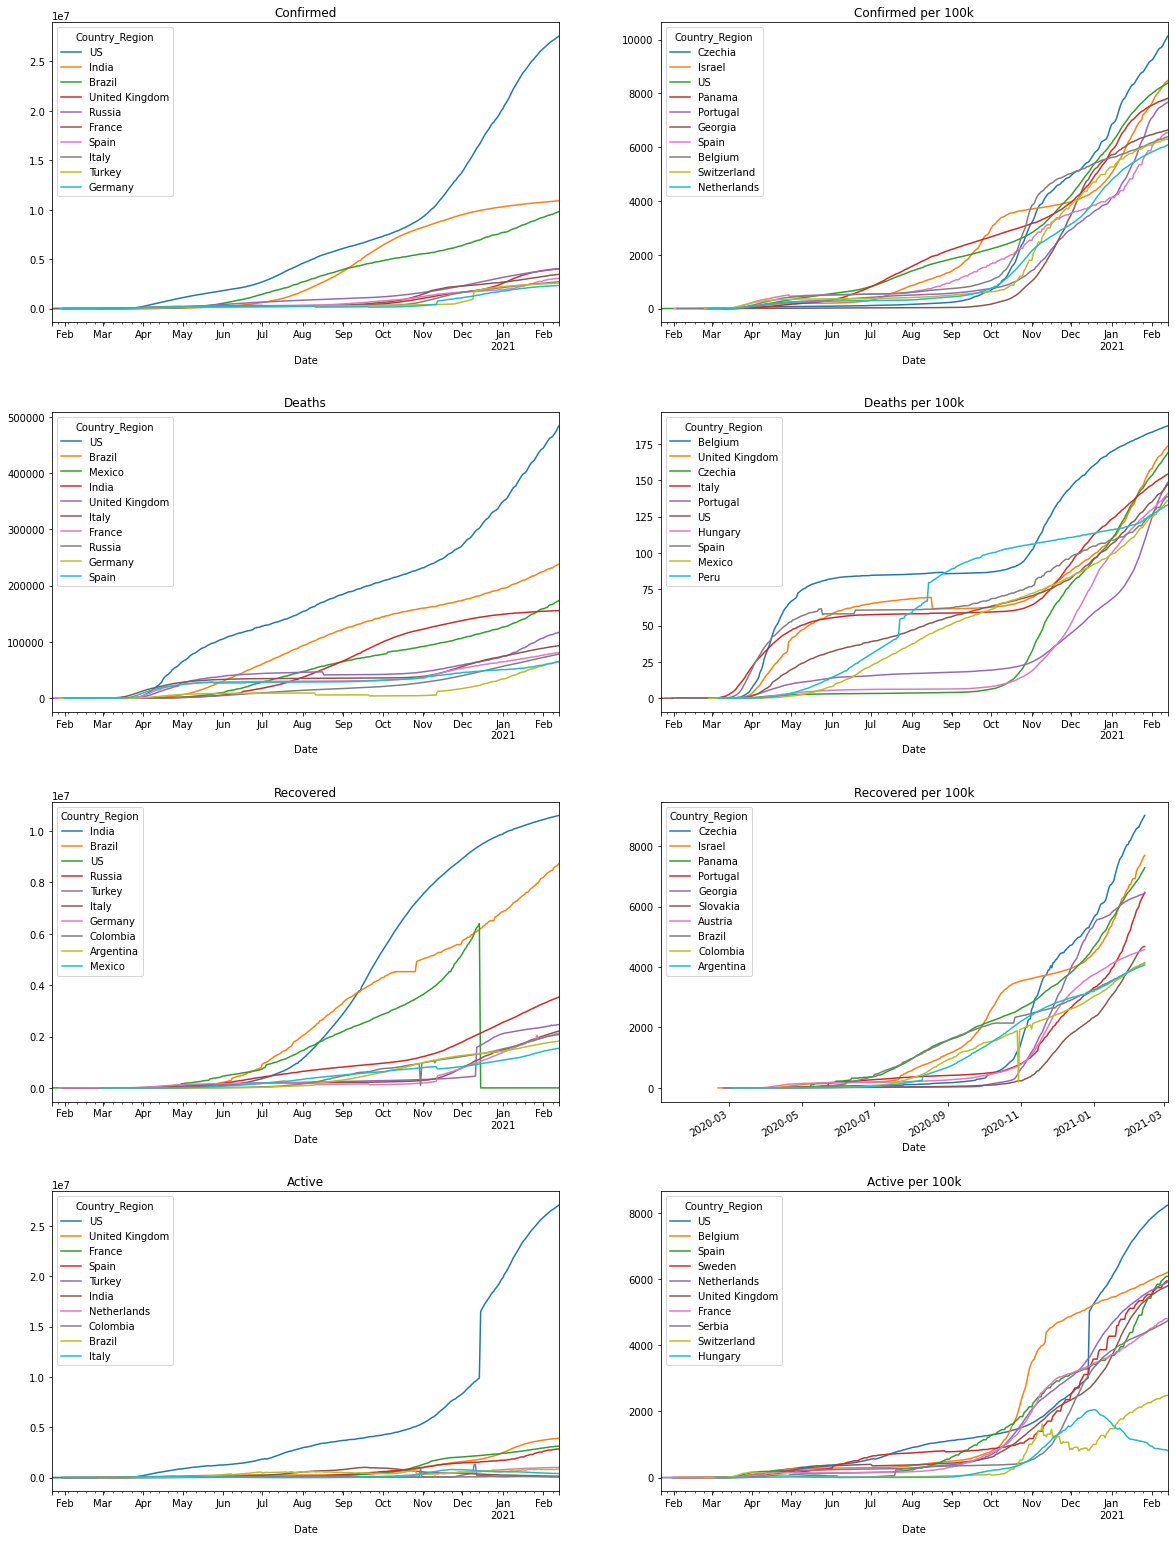

In [38]:
fig, axes = plt.subplots(4, 2, figsize=(20,30))
for i, column in enumerate(covid.columns):
    ax_r = i % 4
    ax_c = int(i/4)
    ax = axes[ax_r, ax_c]
    top_countries = covid_max.nlargest(n=10, columns=column, keep='all').sort_values(by=column, ascending=False).index
    p = covid.loc[top_countries]
    p = p.pivot_table(index=p.index.get_level_values('Date'), 
                      columns=p.index.get_level_values('Country_Region'), 
                      values=column)

    p = p.reindex(columns=top_countries)
    p.plot(title=column.replace('_', ' '), logy=False, ax=ax)

fig.subplots_adjust(hspace=0.3)

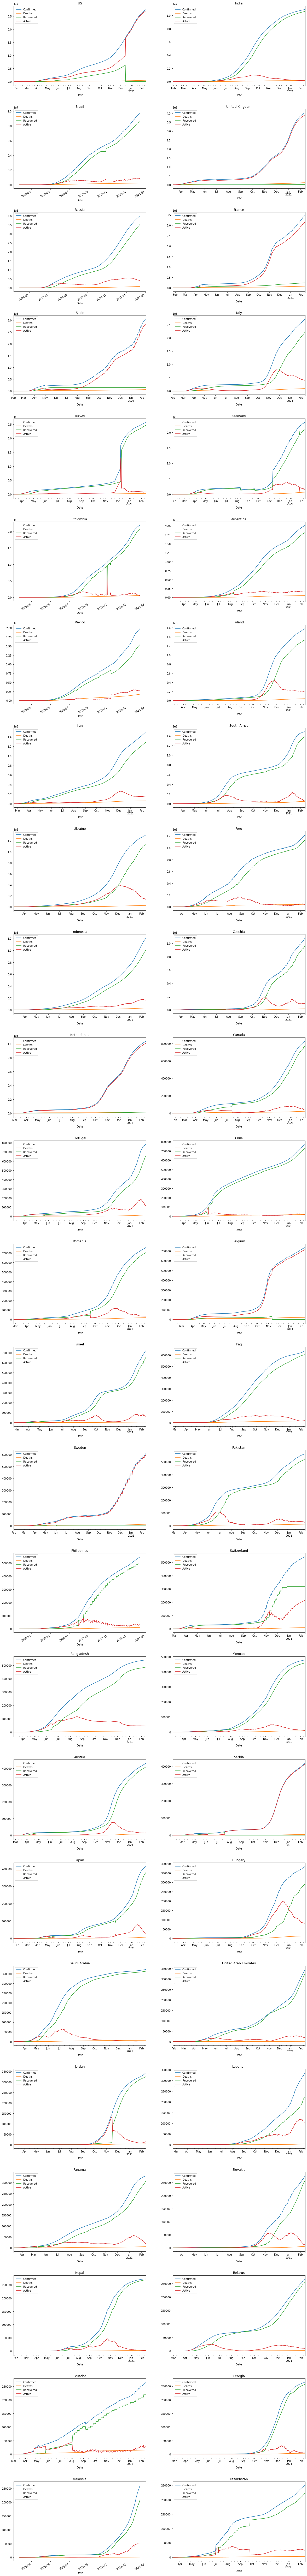

In [39]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country].plot(y=['Confirmed', 'Deaths', 'Recovered', 'Active'], 
                            ax = ax, title=country, logy=False)
    

fig.subplots_adjust(hspace=0.3)

We want to add columns with differences. To smooth the differences we calculate the differences on a rolling window (size 5)

In [40]:
d=covid.groupby(level='Country_Region').rolling(window=ROLLING_WINDOW).mean().diff()
d

Confirmed  Deaths  Recovered  \
Country_Region Country_Region Date                                       
Argentina      Argentina      2020-03-03        NaN     NaN        NaN   
                              2020-03-04        NaN     NaN        NaN   
                              2020-03-05        NaN     NaN        NaN   
                              2020-03-06        NaN     NaN        NaN   
                              2020-03-07        NaN     NaN        NaN   
...                                             ...     ...        ...   
United Kingdom United Kingdom 2021-02-09    16010.0   720.8       83.2   
                              2021-02-10    14784.6   718.2       80.2   
                              2021-02-11    13820.6   688.6       83.2   
                              2021-02-12    13679.4   765.2       77.0   
                              2021-02-13    13522.8   822.8      105.4   

                                           Active  Confirmed_per_100k  \
Country_Region Country_Region Date                                      
Argentina      Argentina      2020-03-03      NaN                 NaN   
                              2020-03-04      NaN                 NaN   
                              2020-03-05      NaN                 NaN   
                              2020-03-06      NaN                 NaN   
                              2020-03-07      NaN                 NaN   
...                                           ...                 ...   
United Kingdom United Kingdom 2021-02-09  15206.0           23.707925   
                              2021-02-10  13986.2           21.893329   
                              2021-02-11  13048.8           20.465818   
                              2021-02-12  12837.2           20.256726   
                              2021-02-13  12594.6           20.024830   

                                          Deaths_per_100k  Recovered_per_100k  \
Country_Region Country_Region Date                                              
Argentina      Argentina      2020-03-03              NaN                 NaN   
                              2020-03-04              NaN                 NaN   
                              2020-03-05              NaN                 NaN   
                              2020-03-06              NaN                 NaN   
                              2020-03-07              NaN                 NaN   
...                                                   ...                 ...   
United Kingdom United Kingdom 2021-02-09         1.067375            0.123204   
                              2021-02-10         1.063525            0.118762   
                              2021-02-11         1.019693            0.123204   
                              2021-02-12         1.133123            0.114023   
                              2021-02-13         1.218419            0.156078   

                                          Active_per_100k  
Country_Region Country_Region Date                         
Argentina      Argentina      2020-03-03              NaN  
                              2020-03-04              NaN  
                              2020-03-05              NaN  
                              2020-03-06              NaN  
                              2020-03-07              NaN  
...                                                   ...  
United Kingdom United Kingdom 2021-02-09        22.517346  
                              2021-02-10        20.711042  
                              2021-02-11        19.322922  
                              2021-02-12        19.009580  
                              2021-02-13        18.650333  

[17967 rows x 8 columns]

For some reason the 1st index level is duplicated

In [41]:
d = d.reset_index(level=0, drop=True)
d

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-03-03        NaN     NaN        NaN      NaN   
               2020-03-04        NaN     NaN        NaN      NaN   
               2020-03-05        NaN     NaN        NaN      NaN   
               2020-03-06        NaN     NaN        NaN      NaN   
               2020-03-07        NaN     NaN        NaN      NaN   
...                              ...     ...        ...      ...   
United Kingdom 2021-02-09    16010.0   720.8       83.2  15206.0   
               2021-02-10    14784.6   718.2       80.2  13986.2   
               2021-02-11    13820.6   688.6       83.2  13048.8   
               2021-02-12    13679.4   765.2       77.0  12837.2   
               2021-02-13    13522.8   822.8      105.4  12594.6   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-03-03                 NaN              NaN   
               2020-03-04                 NaN              NaN   
               2020-03-05                 NaN              NaN   
               2020-03-06                 NaN              NaN   
               2020-03-07                 NaN              NaN   
...                                       ...              ...   
United Kingdom 2021-02-09           23.707925         1.067375   
               2021-02-10           21.893329         1.063525   
               2021-02-11           20.465818         1.019693   
               2021-02-12           20.256726         1.133123   
               2021-02-13           20.024830         1.218419   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2020-03-03                 NaN              NaN  
               2020-03-04                 NaN              NaN  
               2020-03-05                 NaN              NaN  
               2020-03-06                 NaN              NaN  
               2020-03-07                 NaN              NaN  
...                                       ...              ...  
United Kingdom 2021-02-09            0.123204        22.517346  
               2021-02-10            0.118762        20.711042  
               2021-02-11            0.123204        19.322922  
               2021-02-12            0.114023        19.009580  
               2021-02-13            0.156078        18.650333  

[17967 rows x 8 columns]

Verify that the rolling values get reset at the country boundaries

In [42]:
len_of_first_group = d.loc[d.index.get_level_values(0)[0]].shape[0]
len_of_first_group

348

In [43]:
d.iloc[len_of_first_group-ROLLING_WINDOW:len_of_first_group+ROLLING_WINDOW*2]

Confirmed  Deaths  Recovered  Active  \
Country_Region Date                                               
Argentina      2021-02-09     6332.0   173.2     7523.2 -1364.4   
               2021-02-10     6205.0   137.8     6871.6  -804.4   
               2021-02-11     6331.2   152.8     6840.2  -661.8   
               2021-02-12     7029.8   171.6     7039.0  -180.8   
               2021-02-13     7210.4   158.0     6957.4    95.0   
Austria        2020-02-25        NaN     NaN        NaN     NaN   
               2020-02-26        NaN     NaN        NaN     NaN   
               2020-02-27        NaN     NaN        NaN     NaN   
               2020-02-28        NaN     NaN        NaN     NaN   
               2020-02-29        NaN     NaN        NaN     NaN   
               2020-03-01        2.4     0.0        0.0     2.4   
               2020-03-02        3.2     0.0        0.0     3.2   
               2020-03-03        3.6     0.0        0.0     3.6   
               2020-03-04        5.2     0.0        0.0     5.2   
               2020-03-05        6.4     0.0        0.0     6.4   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2021-02-09           14.140028         0.386774   
               2021-02-10           13.856424         0.307722   
               2021-02-11           14.138242         0.341219   
               2021-02-12           15.698289         0.383201   
               2021-02-13           16.101588         0.352831   
Austria        2020-02-25                 NaN              NaN   
               2020-02-26                 NaN              NaN   
               2020-02-27                 NaN              NaN   
               2020-02-28                 NaN              NaN   
               2020-02-29                 NaN              NaN   
               2020-03-01            0.026800         0.000000   
               2020-03-02            0.035734         0.000000   
               2020-03-03            0.040201         0.000000   
               2020-03-04            0.058067         0.000000   
               2020-03-05            0.071468         0.000000   

                           Recovered_per_100k  Active_per_100k  
Country_Region Date                                             
Argentina      2021-02-09           16.800104        -3.046850  
               2021-02-10           15.345012        -1.796311  
               2021-02-11           15.274893        -1.477870  
               2021-02-12           15.718834        -0.403746  
               2021-02-13           15.536613         0.212145  
Austria        2020-02-25                 NaN              NaN  
               2020-02-26                 NaN              NaN  
               2020-02-27                 NaN              NaN  
               2020-02-28                 NaN              NaN  
               2020-02-29                 NaN              NaN  
               2020-03-01            0.000000         0.026800  
               2020-03-02            0.000000         0.035734  
               2020-03-03            0.000000         0.040201  
               2020-03-04            0.000000         0.058067  
               2020-03-05            0.000000         0.071468

In [44]:
covid=covid.join(other=d,rsuffix='_diff')
covid.iloc[80:95]

Confirmed  Deaths  Recovered   Active  \
Country_Region Date                                                
Argentina      2020-05-22    10649.0   433.0     3062.0   7154.0   
               2020-05-23    11353.0   445.0     3530.0   7378.0   
               2020-05-24    12076.0   452.0     3732.0   7892.0   
               2020-05-25    12628.0   467.0     3999.0   8162.0   
               2020-05-26    13228.0   484.0     4167.0   8577.0   
               2020-05-27    13933.0   500.0     4349.0   9084.0   
               2020-05-28    14702.0   508.0     4617.0   9577.0   
               2020-05-29    15419.0   520.0     4788.0  10111.0   
               2020-05-30    16214.0   528.0     4788.0  10898.0   
               2020-05-31    16851.0   539.0     5336.0  10976.0   
               2020-06-01    17415.0   556.0     5521.0  11338.0   
               2020-06-02    18319.0   569.0     5709.0  12041.0   
               2020-06-03    19268.0   583.0     5896.0  12789.0   
               2020-06-04    20197.0   608.0     5993.0  13596.0   
               2020-06-05    21037.0   632.0     6088.0  14317.0   

                           Confirmed_per_100k  Deaths_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22           23.780347         0.966935   
               2020-05-23           25.352454         0.993732   
               2020-05-24           26.966990         1.009364   
               2020-05-25           28.199664         1.042861   
               2020-05-26           29.539528         1.080823   
               2020-05-27           31.113868         1.116553   
               2020-05-28           32.831126         1.134418   
               2020-05-29           34.432263         1.161215   
               2020-05-30           36.207583         1.179080   
               2020-05-31           37.630071         1.203644   
               2020-06-01           38.889543         1.241607   
               2020-06-02           40.908271         1.270637   
               2020-06-03           43.027489         1.301901   
               2020-06-04           45.102045         1.357729   
               2020-06-05           46.977854         1.411323   

                           Recovered_per_100k  Active_per_100k  \
Country_Region Date                                              
Argentina      2020-05-22            6.837771        15.975641   
               2020-05-23            7.882865        16.475857   
               2020-05-24            8.333952        17.623674   
               2020-05-25            8.930191        18.226612   
               2020-05-26            9.305353        19.153351   
               2020-05-27            9.711779        20.285536   
               2020-05-28           10.310251        21.386457   
               2020-05-29           10.692112        22.578936   
               2020-05-30           10.692112        24.336391   
               2020-05-31           11.915854        24.510573   
               2020-06-01           12.328979        25.318957   
               2020-06-02           12.748803        26.888831   
               2020-06-03           13.166394        28.559194   
               2020-06-04           13.383005        30.361311   
               2020-06-05           13.595150        31.971381   

                           Confirmed_diff  Deaths_diff  Recovered_diff  \
Country_Region Date                                                      
Argentina      2020-05-22           516.2         12.0            98.6   
               2020-05-23           596.4         12.6           181.0   
               2020-05-24           653.4         11.8           172.0   
               2020-05-25           669.0         12.8           213.2   
               2020-05-26           659.4         13.6           227.0   
               2020-05-27           656.8         13.4           257.4   
               2020-05-28       

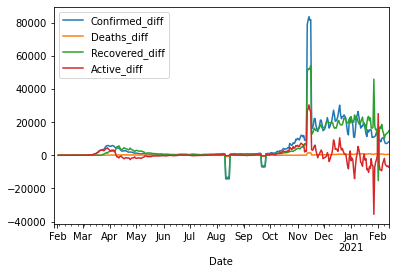

In [45]:
covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].plot()

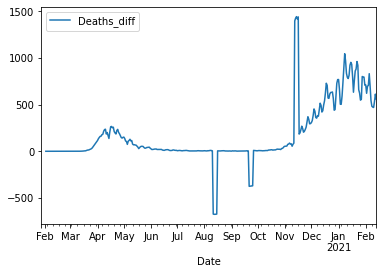

In [46]:
covid.loc[('Germany',),['Deaths_diff']].plot()

In [47]:
display(HTML(covid.loc[('Germany',),['Deaths','Deaths_diff']].to_html()))

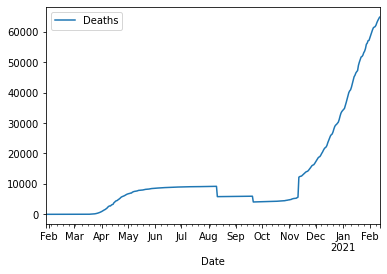

In [48]:
covid.loc[('Germany',),['Deaths']].plot()

In [49]:
display(HTML(covid.loc[('Germany',),['Confirmed_diff', 'Deaths_diff', 'Recovered_diff', 'Active_diff']].to_html()))

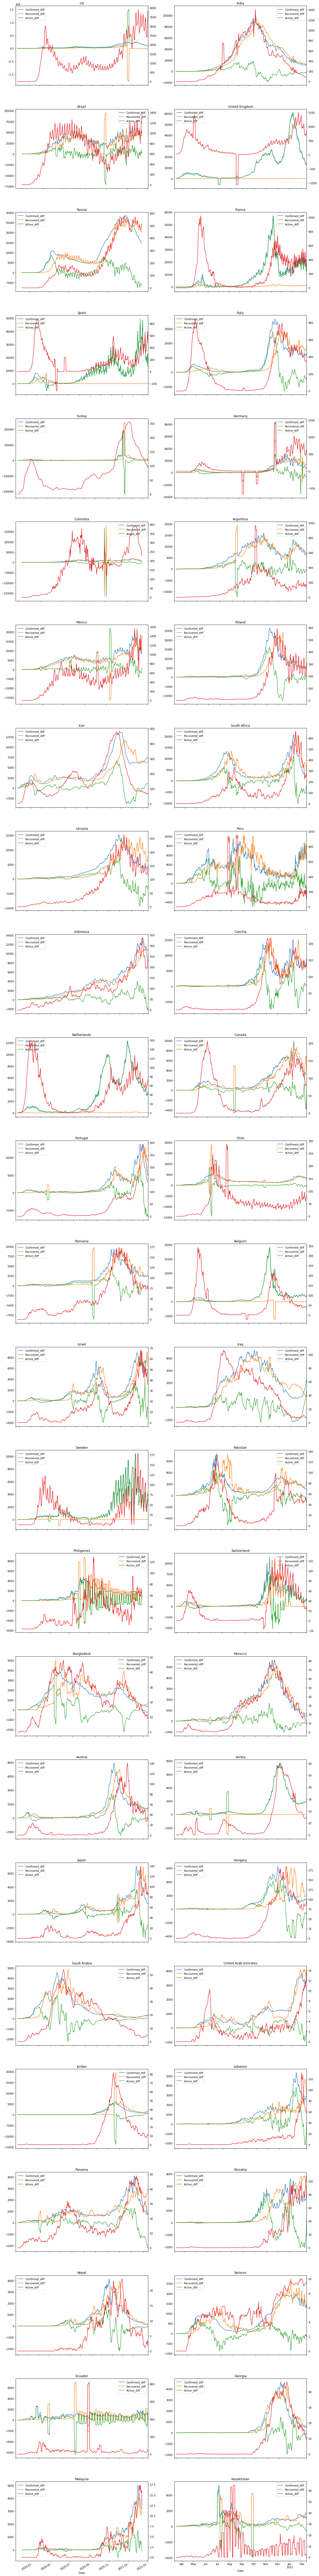

In [50]:
from math import ceil
top_countries = covid_max.nlargest(n=N_TOP_IMPACTED, columns='Confirmed').index
fig, axes = plt.subplots(int(ceil(N_TOP_IMPACTED / 2)), 2, figsize=(20, 4 * N_TOP_IMPACTED))
for i, country in enumerate(top_countries):
    ax_r = int(i / 2)
    ax_c = i % 2
    ax = axes[ax_r, ax_c]
    covid.loc[country,['Confirmed_diff', 'Recovered_diff', 'Active_diff']].plot(ax=ax, title=country)
    ax2=ax.twinx()
    covid.loc[country,['Deaths_diff']].plot(ax=ax2, colormap='Set1')
    ax2.get_legend().remove()
    
fig.subplots_adjust(hspace=0.3)

In [51]:
N_TOP_IMPACTED

50